In [1]:
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade nest-asyncio

     |████████████████████████████████| 819 kB 29.8 MB/s 
     |████████████████████████████████| 65.1 MB 88 kB/s 
     |████████████████████████████████| 4.0 MB 43.8 MB/s 
     |████████████████████████████████| 237 kB 28.6 MB/s 
     |████████████████████████████████| 121 kB 75.1 MB/s 
     |████████████████████████████████| 251 kB 37.6 MB/s 
     |████████████████████████████████| 887 kB 26.8 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
     |████████████████████████████████| 462 kB 74.1 MB/s 
     |████████████████████████████████| 4.2 MB 58.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.28.1 which is incompatible.
pymc3 3.11.4 requires cachetools>=4.2.1, but you have cachetools 3.1.1 which is incompatible.
panel 0.

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found


In [14]:
import nest_asyncio
nest_asyncio.apply()

import collections
import functools
from typing import Callable, List, OrderedDict
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
tf.random.set_seed(1)
np.random.seed(1)
from mimelite import build_federated_averaging_process as mimelite_process

# Settings
TOTAL_CLIENTS = 100  #Set to 3400 when running large scale expts for EMNIST
NUM_CLIENTS_PER_ROUND = 20
BATCH_SIZE = 10
BASE_LR = 0.1
SERVER_LR = 1.0
SERVER_MOMENTUM = 0.0
LOCAL_EPOCHS = 1 #Set to 10 when running large scale expts for EMNIST
NUM_ROUNDS = 100 #Set to 1000 when running large scale expts


def _create_test_cnn_model():
  """A simple CNN model for test."""
  data_format = 'channels_last'
  input_shape = [28, 28, 1]

  max_pool = functools.partial(
      tf.keras.layers.MaxPooling2D,
      pool_size=(2, 2),
      padding='same',
      data_format=data_format)
  conv2d = functools.partial(
      tf.keras.layers.Conv2D,
      kernel_size=5,
      padding='same',
      data_format=data_format,
      activation=tf.nn.relu)

  model = tf.keras.models.Sequential([
      conv2d(filters=32, input_shape=input_shape),
      max_pool(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10),
      tf.keras.layers.Activation(tf.nn.softmax),
  ])

  return model

def _simple_model_fn():
  keras_model = _create_test_cnn_model()
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
  input_spec = collections.OrderedDict(
      x=tf.TensorSpec([None, 28, 28, 1], tf.float32),
      y=tf.TensorSpec([None], tf.int32))
  return tff.learning.from_keras_model(
      keras_model=keras_model, input_spec=input_spec, loss=loss, metrics=metrics)

federated_algorithm = mimelite_process(_simple_model_fn,
                           optimizer_fn=tf.keras.optimizers.SGD,
                           base_lr=BASE_LR,
                           server_lr=SERVER_LR,
                           server_momentum=SERVER_MOMENTUM)


federated_data_type = federated_algorithm.next.type_signature.parameter[1]

server_state = federated_algorithm.initialize()

emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()


def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch of EMNIST data and return a (features, label) tuple."""
    return (tf.reshape(element['pixels'], [-1, 28, 28, 1]), 
            element['label'])

  return dataset.repeat(LOCAL_EPOCHS).batch(BATCH_SIZE).map(batch_format_fn)

train_client_ids = sorted(emnist_train.client_ids)[:TOTAL_CLIENTS]
federated_train_data = [preprocess(emnist_train.create_tf_dataset_for_client(x))
  for x in train_client_ids
]

test_client_ids = sorted(emnist_test.client_ids)[:TOTAL_CLIENTS]
federated_test_data = [preprocess(emnist_test.create_tf_dataset_for_client(x))
  for x in test_client_ids
]


mime_train_round_loss_list = []
mime_test_loss_list = []
mime_test_accuracy_list = []

evaluation = tff.learning.build_federated_evaluation(_simple_model_fn)


for i in range(NUM_ROUNDS):
    random_state = np.random.RandomState(seed=2)
    sampled_client_ids_data = random_state.choice(federated_train_data, size=NUM_CLIENTS_PER_ROUND).tolist()
    server_state, train_round_loss = federated_algorithm.next(server_state, sampled_client_ids_data)
    
    
    # test_metrics = evaluation(server_state.model, federated_test_data)
    # test_loss = test_metrics['eval']['loss']
    # test_accuracy = test_metrics['eval']['sparse_categorical_accuracy']

    mime_train_round_loss_list.append(train_round_loss)
    # mime_test_loss_list.append(test_loss)
    # mime_test_accuracy_list.append(test_accuracy)
    
    # print(f"Round:{i+1}, Train round loss:{train_round_loss:.4f}, Test loss:{test_loss:.4f}, Test accuracy:{test_accuracy:.4f}")
    print(f"Round:{i+1}, Train round loss:{train_round_loss:.4f}")

Round:1, Train round loss:2.8185
Round:2, Train round loss:2.3069
Round:3, Train round loss:2.3077
Round:4, Train round loss:2.2991
Round:5, Train round loss:2.3016
Round:6, Train round loss:2.2838
Round:7, Train round loss:2.3176
Round:8, Train round loss:2.2842
Round:9, Train round loss:2.2847
Round:10, Train round loss:2.2709
Round:11, Train round loss:2.2699
Round:12, Train round loss:2.2272
Round:13, Train round loss:2.2442
Round:14, Train round loss:2.1320
Round:15, Train round loss:2.0804
Round:16, Train round loss:1.8345
Round:17, Train round loss:1.6063
Round:18, Train round loss:1.4054
Round:19, Train round loss:1.2306
Round:20, Train round loss:0.9995
Round:21, Train round loss:0.8571
Round:22, Train round loss:0.7551
Round:23, Train round loss:0.6732
Round:24, Train round loss:0.6118
Round:25, Train round loss:0.5619
Round:26, Train round loss:0.5186
Round:27, Train round loss:0.4860
Round:28, Train round loss:0.4546
Round:29, Train round loss:0.4309
Round:30, Train round l

In [13]:
import nest_asyncio
nest_asyncio.apply()

import collections
import functools
from typing import Callable, List, OrderedDict
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
tf.random.set_seed(1)
np.random.seed(1)
import simple_fedavg_tf
from simple_fedavg_tf import build_server_broadcast_message
from simple_fedavg_tf import client_update
from simple_fedavg_tf import server_update
from simple_fedavg_tf import ServerState
from simple_fedavg_tff import build_federated_averaging_process as fed_avg_process

# Settings
TOTAL_CLIENTS = 100  #Set to 3400 when running large scale expts for EMNIST
NUM_CLIENTS_PER_ROUND = 20
BATCH_SIZE = 10
BASE_LR = 0.1
SERVER_LR = 1.0
SERVER_MOMENTUM = 0.9
LOCAL_EPOCHS = 1 #Set to 10 when running large scale expts for EMNIST
NUM_ROUNDS = 100 #Set to 1000 when running large scale expts


def _create_test_cnn_model():
  """A simple CNN model for test."""
  data_format = 'channels_last'
  input_shape = [28, 28, 1]

  max_pool = functools.partial(
      tf.keras.layers.MaxPooling2D,
      pool_size=(2, 2),
      padding='same',
      data_format=data_format)
  conv2d = functools.partial(
      tf.keras.layers.Conv2D,
      kernel_size=5,
      padding='same',
      data_format=data_format,
      activation=tf.nn.relu)

  model = tf.keras.models.Sequential([
      conv2d(filters=32, input_shape=input_shape),
      max_pool(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10),
      tf.keras.layers.Activation(tf.nn.softmax),
  ])

  return model

def _simple_model_fn():
  keras_model = _create_test_cnn_model()
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
  input_spec = collections.OrderedDict(
      x=tf.TensorSpec([None, 28, 28, 1], tf.float32),
      y=tf.TensorSpec([None], tf.int32))
  return tff.learning.from_keras_model(
      keras_model=keras_model, input_spec=input_spec, loss=loss, metrics=metrics)
  


federated_algorithm = fed_avg_process(_simple_model_fn, 
                                      server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=SERVER_LR),
                                      client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=BASE_LR))



federated_data_type = federated_algorithm.next.type_signature.parameter[1]

server_state = federated_algorithm.initialize()

emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()


def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch of EMNIST data and return a (features, label) tuple."""
    return (tf.reshape(element['pixels'], [-1, 28, 28, 1]), 
            element['label'])

  return dataset.repeat(LOCAL_EPOCHS).batch(BATCH_SIZE).map(batch_format_fn)

train_client_ids = sorted(emnist_train.client_ids)[:TOTAL_CLIENTS]
federated_train_data = [preprocess(emnist_train.create_tf_dataset_for_client(x))
  for x in train_client_ids
]

test_client_ids = sorted(emnist_test.client_ids)[:TOTAL_CLIENTS]
federated_test_data = [preprocess(emnist_test.create_tf_dataset_for_client(x))
  for x in test_client_ids
]


fedavg_train_round_loss_list = []
fedavg_test_loss_list = []
fedavg_test_accuracy_list = []

evaluation = tff.learning.build_federated_evaluation(_simple_model_fn)


for i in range(NUM_ROUNDS):
    random_state = np.random.RandomState(seed=2)
    sampled_client_ids_data = random_state.choice(federated_train_data, size=NUM_CLIENTS_PER_ROUND).tolist()
    server_state, train_round_loss = federated_algorithm.next(server_state, sampled_client_ids_data)
    
    
    # test_metrics = evaluation(server_state.model, federated_test_data)
    # test_loss = test_metrics['eval']['loss']
    # test_accuracy = test_metrics['eval']['sparse_categorical_accuracy']

    fedavg_train_round_loss_list.append(train_round_loss['loss'])
    # fedavg_test_loss_list.append(test_loss)
    # fedavg_test_accuracy_list.append(test_accuracy)
    
    # print(f"Round:{i+1}, Train round loss:{train_round_loss:.4f}, Test loss:{test_loss:.4f}, Test accuracy:{test_accuracy:.4f}")
    print("Round:", i+1, "Train round loss:", train_round_loss['loss'])

Round: 1 Train round loss: 2.8155591
Round: 2 Train round loss: 2.298725
Round: 3 Train round loss: 2.3201835
Round: 4 Train round loss: 2.3046067
Round: 5 Train round loss: 2.3007627
Round: 6 Train round loss: 2.3085458
Round: 7 Train round loss: 2.2981791
Round: 8 Train round loss: 2.2844596
Round: 9 Train round loss: 2.2658463
Round: 10 Train round loss: 2.2864985
Round: 11 Train round loss: 2.2311811
Round: 12 Train round loss: 2.194161
Round: 13 Train round loss: 2.1166382
Round: 14 Train round loss: 1.9936764
Round: 15 Train round loss: 1.8310896
Round: 16 Train round loss: 1.6846547
Round: 17 Train round loss: 1.4939336
Round: 18 Train round loss: 1.3845017
Round: 19 Train round loss: 1.272975
Round: 20 Train round loss: 1.1873394
Round: 21 Train round loss: 1.1237324
Round: 22 Train round loss: 1.0696691
Round: 23 Train round loss: 1.0207018
Round: 24 Train round loss: 0.9862659
Round: 25 Train round loss: 0.9506903
Round: 26 Train round loss: 0.92364645
Round: 27 Train round l

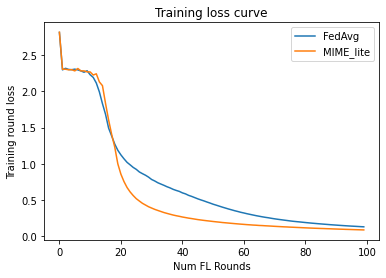

In [15]:
import matplotlib.pyplot as plt

plt.plot(fedavg_train_round_loss_list, label='FedAvg')
plt.plot(mime_train_round_loss_list, label='MIME_lite')
plt.title("Training loss curve")
plt.xlabel("Num FL Rounds")
plt.ylabel("Training round loss")
plt.legend()